# CLIP<sup>n</sup> integration on 13 datasets of drug responses
Note: This experiment was conducted before the CLIP<sup>n</sup> package was organized for release. The code is not compatible with the current version of the package.

In [1]:
import sys

sys.path.append('/code')
from CLIPn import CLIPn
from functions.helper import *
import umap
import plotly.express as px

## Load data and analyze the compound categories
Only compound categories profiled in more than one datasets are kept.

In [2]:
# map compound category into numbers
category_all = pd.Series()
for data_i in range(13):
    meta = pd.read_csv('database/{}_meta_final.csv'.format(data_i))
    # print(meta.shape)
    category_all = pd.concat([category_all, pd.Series(meta['Compound_Category'].unique())], ignore_index=True)
    # category_all.append(meta['Compound_Category'].unique(), ignore_index=True)
a = category_all.value_counts()

a = a[a > 1]

category_map = dict(zip(a.index, range(a.index.size)))
reverse_map = dict(zip(range(a.index.size), a.index))
a

/home/fbao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


tubulin polymerization inhibitor           13
HDAC inhibitor                             11
mTOR inhibitor                             10
HSP inhibitor                               9
DNA inhibitor                               9
proteasome inhibitor                        8
bromodomain inhibitor                       6
Aurora kinase inhibitor                     6
MEK inhibitor                               6
glucocorticoid receptor agonist             6
CDK inhibitor                               6
PI3K inhibitor                              5
EGFR inhibitor                              5
dopamine receptor antagonist                4
PLK inhibitor                               4
bacterial cell wall synthesis inhibitor     4
cyclooxygenase inhibitor                    3
ATPase inhibitor                            3
HMGCR inhibitor                             3
Actin                                       3
MAPK inhibitor                              3
rho associated kinase inhibitor   

UMAP plot functions

In [3]:
def umap_embedding(Z: dict, y: dict):
    Z, y, id = dict_to_array(Z, y)

    umap_ = umap.UMAP()

    umap_.fit(Z)

    embed = umap_.transform(Z)

    plot_pd = pd.DataFrame({'x': embed[:, 0], 'y': embed[:, 1], 'label': y, 'dataset': id})

    plot_pd['facet'] = plot_pd['label']

    # plot_pd.facet[plot_pd.facet > 3] = 3

    plot_pd.label.replace(reverse_map, inplace=True)

    fig = px.scatter(plot_pd[plot_pd.facet < 10], x='x', y='y', color='label', symbol='dataset', height=600,
                     width=800, )
    fig.show()

    fig = px.scatter(plot_pd[(plot_pd.facet < 20) & (plot_pd.facet >= 10)], x='x', y='y', color='label',
                     symbol='dataset', height=600, width=800, )
    fig.show()

    fig = px.scatter(plot_pd[(plot_pd.facet < 30) & (plot_pd.facet >= 20)], x='x', y='y', color='label',
                     symbol='dataset', height=600, width=800, )
    fig.show()

    fig = px.scatter(plot_pd[(plot_pd.facet >= 30)], x='x', y='y', color='label',
                     symbol='dataset', height=600, width=800, )
    fig.show()

    plt.figure(figsize=(8, 8))
    sns.scatterplot(data=plot_pd, x='x', y='y', hue='dataset', palette='tab10', s=1)
    plt.show()

### Wrap datasets into dictionary

In [4]:
X = dict()
y = dict()

for i in range(13):
    feature = pd.read_csv('database/{}_feature_final.csv'.format(i))
    meta = pd.read_csv('database/{}_meta_final.csv'.format(i))

    feature = feature[meta.Compound_Category.isin(a.index.to_list())]
    meta = meta[meta.Compound_Category.isin(a.index.to_list())]

    X[i] = feature.values
    # X[i] = zscore(feature.values, axis=0)
    y[i] = meta['Compound_Category'].map(category_map).values

### Train CLIP<sup>n</sup> model and visualize the latent space

Running CLIPn ...


  0%|          | 0/5000 [00:00<?, ?it/s]

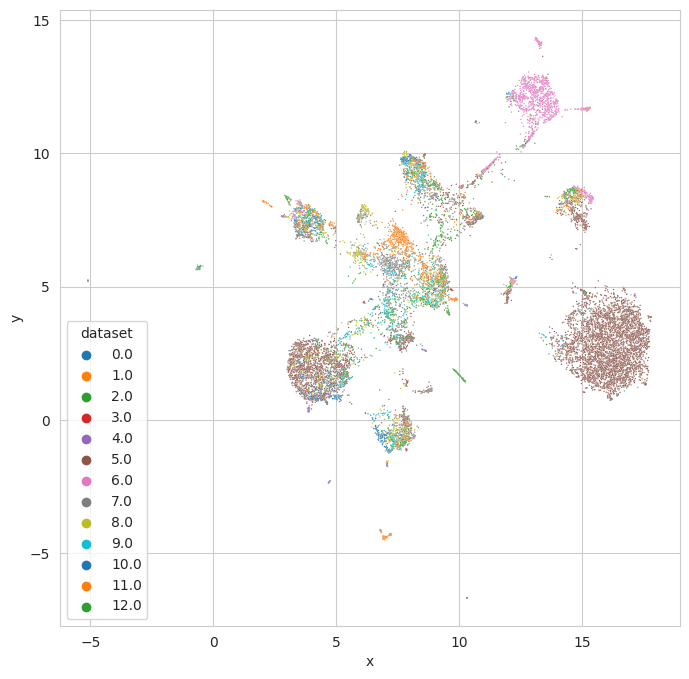

In [5]:
clpn = CLIPn(X, y, latent_dim=10, gpu='cuda:3')
loss = clpn.fit(X, y)
z_clipn = clpn.predict(X)
umap_embedding(z_clipn, y)